### Sankey

This script is used to aggregate all minor league batter promotions. Included are all batters who started their minor league careers between 1990 and 2011. The result of this scrip was used to create this [Sankey Diagram](http://blockbuilder.org/leem99/eee9931926c08b1fcd6ffbe1604547a6).


__Caveats__
* Minor leaguers who did not play at least two seasons above the rookie leagues are excluded.
* Independent leagues, winter leagues, and foreign leagues are excluded.
* It is assumed that all players were promoted in by level of difficulty. (i.e. a player did not go from A+ to AAA, and back down to AA).
* All players in the data set are currently retired. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
import re

#Sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import linear_model
from sklearn import metrics
from sklearn import ensemble

#Display
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns',None)
%matplotlib inline

In [2]:
batter_profiles = pd.read_csv('milb_batter_summaries.csv')
batter_seasons = pd.read_csv('milb_all_batter_seasons.csv')

In [3]:
len(batter_profiles.milb_id.unique())

17525

__Helper Functions__

Add Useful Data Fields

In [4]:
def add_season_number(df):
    first_year = pd.DataFrame()
    first_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df

def add_success_year(df):
    success_year = pd.DataFrame()
    success_year['FirstYear'] = df.groupby(['milb_id']).min()['Year']
    first_year = first_year.reset_index()
    df = df.merge(first_year, how = 'outer')
    
    df['SeasonNumber'] = df['Year'] - df['FirstYear'] + 1
    #df = df.drop('First_Year',axis = 1)
    return df


Add Stat Calulation Functions

In [5]:
## Batting Average
# Number of Hits (divided by) Number of At Bats

# Calculate the number of single from other hit data
def calc_singles(df):
    df['1B'] = df['H'] - df['2B'] - df['3B'] - df['HR']
    return df

def calc_BA(df):
    ba_series = df['H']/df['AB']
    return ba_series
    
## Slugging Percentage
# Number of (Singles + [2 x Doubles] +[ 3 x Triples] + [4 x Home Runs]) divided by At Bats  
def calc_SLG(df):
    slg_series = (df['1B'] + 2*df['2B'] + 3*df['3B'] + 4*df['HR']) / df['AB']
    return slg_series

## On Base Percentage
# (Hits + Walks + Hit-By-Pitch) divided by (At Bats + Walks+ Hit-By-Pitch + Sac Flys)
def calc_OBP(df):
    obp_series = (df['H'] + df['BB'] + df['HBP']) \
        / (df['AB'] + df['BB'] + df['HBP']+df['SF']) 
    return obp_series

## On Base Plus Slugging 
def calc_OPS(df):
     # On Base Plus Slugging 
    ops_series = calc_OBP(df) + calc_SLG(df)
    return ops_series

Add Aggregation Function

In [6]:
# Aggregate year by year stats into full career data.
# Requires the recalculation of rate based stats from their definitions.
def make_season_stats(df):
    
    counting_stats = ['G', 'PA', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB',
       'CS', 'BB', 'SO','TB', 'GDP', 'HBP','SH', 'SF', 'IBB']
    
    
    if 'LevNum' in df.columns:
        df['LevWeight'] = df['LevNum']*df['PA']
    
    
    # Make groupby object to only do aggregation once
    grouped_obj = df.groupby(['milb_id','Year'])
    
    df_grouped = grouped_obj.sum()
    
    df_grouped['1B'] = calc_singles(df_grouped)
    
    # Batting Average 
    df_grouped['BA'] = calc_BA(df_grouped)
    
    # On Base Percentage
    df_grouped['OBP'] = calc_OBP(df_grouped)
    
    # Slugging Percentage
    df_grouped['SLG'] = calc_SLG(df_grouped)
    
    # On Base Plus Slugging 
    df_grouped['OPS'] = calc_OPS(df_grouped)
    
    # Other BIO 
    # Fields where max is most important 
    test_fields = ['Age','FirstYear',
                   'SeasonNumber','SuccessYear']
    for tf in test_fields:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].max()
            
    # fields where min is most importand
    test_fields2 = ['AgeDif']
    for tf in test_fields2:
        if tf in df_grouped.columns:
            df_grouped[tf] = grouped_obj[tf].min()
                  
    # Minor League Level Attributs
    if 'LevNum' in df.columns:
        df_grouped['LevWeighted'] = df_grouped['LevWeight']/df_grouped['PA']
        
        df_grouped['LevCount'] = grouped_obj.count()['Lev']
        df_grouped.drop('LevWeight', axis=1, inplace=True)
    
    df_grouped.reset_index(inplace=True)
    
    return df_grouped


Function for creating rate stats

In [7]:
def make_rate_stats(df):
    
    df['HR_rate'] = df['HR']/df['PA']
    df['BB_rate'] = df['BB']/df['PA']
    df['SO_rate'] = df['SO']/df['PA']
    df['IBB_rate'] = df['IBB']/df['PA']
    df['SB_rate'] = df['SB']/df['PA'] #None standard definition
    df['SB_percentage'] = df['SB']/(df['SB']+df['CS'])
    df.loc[np.isnan(df['SB_percentage']),['SB_percentage']] = 0
    
    df['GDP_rate'] = df['GDP']/df['PA']
    df['SH_rate'] = df['SH']/df['PA']
    df['SF_rate'] = df['SF']/df['PA']
    df['HBP_rate'] = df['HBP']/df['PA']
    
    
    df['SB_percentage']
    
    return df

Function to Convert Player Profile into Useful Features

In [8]:
def make_batter_profile_features(df):
    df_cleaned  = deepcopy(df)

    # --- Bats --- 
    # Try to add natural order to batting to see 
    # if it can help logistic regression too
    df_cleaned.loc[
        df_cleaned['bats'] == 'right','bats'] = 0
    df_cleaned.loc[
        df_cleaned['bats'] == 'left','bats'] = 1
    df_cleaned.loc[
        df_cleaned['bats'] == 'both','bats'] = 2

    # --- Throws --- 
    df_cleaned.loc[
        df_cleaned['throws'] == 'right','throws'] = 0
    df_cleaned.loc[
        df_cleaned['throws'] == 'left','throws'] = 1

    # --- Draft ---
    df_cleaned['draft'].fillna(value = -1, inplace=True)

    # --- Positions ---
    df_cleaned['positions'] = df['positions'].str.split(',|and')
    df_cleaned['positions'] = df_cleaned['positions'].str.get(0)
    df_cleaned['positions'] = df_cleaned['positions'].str.lower()
    df_cleaned['position_difficulty'] = df_cleaned['positions'].str.lower()

    # Crudly bin positions by value. Not specifying fielders, because older records 
    # do not designate between left, right, and center.
    pos_list = ['designated','first','fielder','third','second','catcher','shortstop']

    for p in pos_list:
        if p == 'designated':
            p_num = '0'
        elif p == 'first':
            p_num = '1'
        elif p in ['fielder','third','second']:
            p_num = '2'
        elif p in ['catcher','shortstop']:
            p_num = '3'

        df_cleaned.loc[
            df_cleaned['position_difficulty'].str.contains(p),'position_difficulty'] = p_num
        
    keep_cols = ['milb_id','draft','bats',
                     'throws','height','weight','position_difficulty']
        
    return df_cleaned[keep_cols]

Helper Function For Assessing Model Fit

In [9]:
def make_summary(pred_dict,y_test):
    summary_list = []
    for k in pred_dict.keys():
        temp_dict = {}
        temp_dict['model'] = k
        temp_dict['logloss'] = metrics.log_loss(y_test,pred_dict[k])
        temp_dict['accuracy'] = metrics.accuracy_score(
            y1_test,
            np.round(pred_dict[k][:,1]))

        # Precision Recall Metrics
        p, r, f, s = metrics.precision_recall_fscore_support(
            y_test,
            np.round(pred_dict[k][:,1]),
            labels = [0,1])
        temp_dict['precision'] = p[1]
        temp_dict['recall'] = r[1]
        temp_dict['f1'] = f[1]
        temp_dict['summprt'] = s[1]

        # AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_dict[k][:,1])
        temp_dict['auc'] = metrics.auc(fpr, tpr)   

        # Append Results to List
        summary_list.append(temp_dict)

    # Put Results in DataFrame
    results1_df = pd.DataFrame(summary_list)
    results1_df.set_index(results1_df.model,inplace = True)
    return results1_df

def make_precision_recall_curves(pred_dict,y_test):
    leg = []
    plt.figure(figsize=(8, 6))
    for k in pred_dict.keys():
        prec, recall, thresholds = metrics.precision_recall_curve(
            y_test,pred_dict[k][:,1])

        plt.plot(prec[0:-1], recall[0:-1])
        leg.append(k)

    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.legend(leg)
    plt.title('Multiple Models: Attempt 1')

def make_roc_curves(pred_dict,y_test):
    leg = []
    plt.figure(figsize=(8, 6))
    for k in pred_dict.keys():
        fpr, tpr, thresholds = metrics.roc_curve(y_test,pred_dict[k][:,1])
        plt.plot(fpr, tpr)
        leg.append(k)
        
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))    
    plt.legend(leg)
    plt.title('Multiple Models: ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('Recall')

def make_feature_importance_charts(pred_dict,model_dict,X):
    num_subplots = len(pred_dict.keys())
    f, axs = plt.subplots(num_subplots,1,figsize=(20,6*num_subplots))
    f.subplots_adjust(hspace=.5)

    count = 1

    for k in pred_dict.keys():
        if 'lm' in k:
            f_Series = pd.Series(
                model_dict[k].coef_[0],index = X.columns[1:]).sort_values()
        elif 'gs' in k:
            f_Series = pd.Series(model_dict[k].best_estimator_.feature_importances_,
                                 index = X.columns[1:]).sort_values()
        else:
            f_Series = pd.Series(model_dict[k].feature_importances_,index = X.columns[1:]).sort_values()

        plt.subplot(num_subplots,1,count)
        g = sns.barplot(x = f_Series.index,y = f_Series)
        g.set_xticklabels(f_Series.index, rotation=-30,size=12)
        plt.title(k, size = 16)
        plt.ylabel('Feature Importance',size=14);
        plt.xlabel('Feature',size=14);
        count += 1
        

__Filtering and Aggregation__

In [10]:
batter_seasons_filt = deepcopy(batter_seasons)

# Drop Aggregated Seasons. Will Recompute
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt.Tm.str.contains('Teams') == False]

In [11]:
# Map Each League to a level
lev_dict = {'FRk':0,'Rk':1,'A-':2,'A':3,'A+':4,'AA':5,'AAA':6,'mlb':7}
level_map = pd.Series(batter_seasons_filt.loc[:,('Lev')].map(lev_dict))
batter_seasons_filt['LevNum'] = level_map

# Drop Leagues that are "Atypical"
weird_leagues = ['Ind','Rk','FRk','WRk','FgW','Fal','Fgn','Wtr']
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lev'].isin(weird_leagues) == False]
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['Lg'] != 'MEX']

In [12]:
# Remove Players Who had their first season before 1990.
batter_seasons_filt = add_season_number(batter_seasons_filt)
batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] > 1990]

batter_seasons_filt = batter_seasons_filt[
    batter_seasons_filt['FirstYear'] < 2012]

In [13]:
# Remove Seasons that occured after player made the majors
majors_df = batter_seasons_filt[
    batter_seasons_filt.Lev == 'MLB'][['milb_id','Year']]

mlb_debuts = majors_df.groupby('milb_id').min().reset_index()
mlb_debuts.rename(columns={'Year':'SuccessYear'},inplace=True)

batter_seasons_filt = batter_seasons_filt.merge(
    mlb_debuts, how = 'left',on= 'milb_id')

batter_seasons_filt = batter_seasons_filt[
    (batter_seasons_filt['SuccessYear'] > batter_seasons_filt['Year']) | 
    pd.isnull(batter_seasons_filt['SuccessYear'])] 


In [14]:
batter_seasons_total = make_season_stats(batter_seasons_filt)
batter_seasons_total = make_rate_stats(batter_seasons_total)

In [15]:
## Add dependent variable
batter_seasons_total = batter_seasons_total.merge(
    batter_profiles.loc[:,['milb_id','mlb']],
    how = 'left',
    on = 'milb_id')

In [16]:
bst_test = deepcopy(batter_seasons_total)

In [17]:
bst_test = bst_test.loc[bst_test['SeasonNumber'] == 2,:]
bst_test = bst_test.loc[bst_test['PA'] > 150,:]

### Exploratory Data Visualization

In [18]:
test = deepcopy(batter_seasons_total)

test.loc[pd.notnull(test['SuccessYear']),'LevWeighted'] = 7 
test.LevWeighted = np.ceil(test.LevWeighted)


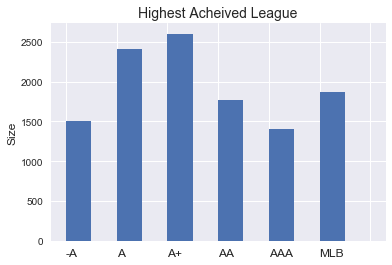

In [19]:
max_leagues = test.groupby('milb_id')['LevWeighted'].max()

x = [2,3,4,5,6,7,8]
labels = ['-A','A','A+','AA','AAA','MLB']
plt.hist(max_leagues.dropna(),bins=x,width=0.5)
plt.xticks(x,labels,ha='left',size = 12)
plt.ylabel('Size',size = 12)
plt.title('Highest Acheived League',size = 14)


Test Data For Sankey

In [20]:
batter_seasons_filt2 = deepcopy(batter_seasons_filt)

In [21]:
# Map Each League to a level
lev_dict = {'FRk':0,'Rk':1,'A-':2,'A':3,'A+':4,'AA':5,'AAA':6,'MLB':7}
level_map = pd.Series(batter_seasons_filt2.loc[:,('Lev')].map(lev_dict))
batter_seasons_filt2['LevNum'] = level_map
batter_seasons_filt2 = batter_seasons_filt2[['milb_id','Tm','Lev','LevNum','mlb_id','Year','FirstYear']]

In [44]:
#Number of Players
np.shape(batter_seasons_filt2.groupby('milb_id').sum())

(11558, 3)

Determine Min Level, Max Level, and Career WAR if Applicable

In [45]:
max_level = pd.DataFrame(batter_seasons_filt.groupby('milb_id')['LevNum'].max())
max_level['Start'] = batter_seasons_filt.groupby('milb_id')['LevNum'].min()

max_level.reset_index(inplace=True)
max_level = max_level.merge(
    batter_profiles.loc[:,['milb_id','war']],
    how = 'left',
    on = 'milb_id')

max_level.loc[pd.notnull(max_level['war']),'LevNum'] = 7.0
max_level.loc[max_level['war']>5,'LevNum'] = 8.0
max_level.loc[max_level['war']>50,'LevNum'] = 9.0
max_level

,milb_id,LevNum,Start,war
0,aalber001bra,3.0,3.0,NaN
1,aaron001ogi,4.0,4.0,NaN
2,abad001fau,7.0,4.0,-0.4
3,abate001mic,4.0,2.0,NaN
4,abbe001chr,5.0,2.0,NaN
5,abbott002cha,6.0,2.0,NaN
6,abbott002jef,7.0,3.0,-1.4
7,abeita001mit,4.0,2.0,NaN
8,abell001sco,3.0,2.0,NaN
9,abercr001joh,5.0,3.0,NaN


In [46]:
# Rename Axis
max_level['LevMax'] = max_level.LevNum 
max_level.drop(['LevNum'],axis =1 ,inplace=True)

In [29]:
batter_seasons_filt['all_ones'] = 1

In [51]:
table = pd.pivot_table(batter_seasons_filt, values='all_ones', index=['milb_id'],
                    columns=['LevNum'], aggfunc=np.mean).reset_index()

In [52]:
table[1.0] = 1
table[7.0]=np.nan
table[8.0]=np.nan
table[9.0]=np.nan
table[10.0]=1

In [57]:
table = table.reindex(columns=['milb_id',1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0])

In [58]:
table = table.merge(max_level,how = 'left',on='milb_id')

In [59]:
# Players who made it to the majors
table.loc[table['LevMax']==7,7.0] = 7

# Players who accumlated 5 WAR (by definition made the majors)
table.loc[table['LevMax']==8,8.0] = 8
table.loc[table['LevMax']==8,7.0] = 7

# Players who accumlated 50 WAR (by definition made the majors, and got 5 WAR)
table.loc[table['LevMax']==9,9.0] = 9
table.loc[table['LevMax']==9,8.0] = 8
table.loc[table['LevMax']==9,7.0] = 7

In [60]:
c_list = [2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]

In [61]:
table = table.drop(axis = 1,labels = ['Start','war','LevMax'])

In [62]:
table = table.set_index('milb_id')

In [63]:
table.columns =  list(map(int,table.columns))

In [64]:
for c in table.columns:
    table.loc[table.loc[:,c].notnull(),c] = c

In [65]:
# Dictionary of all leagues for each player

p_dict = dict()
for ix in table.index:
    p_dict[ix] = list(map(int,table.loc[ix,table.loc[ix,:].notnull()]))

In [66]:
# Count the number of players who made each type of league jump
tup_dict = defaultdict(int)

for k in p_dict.keys():
    temp_list = p_dict[k]
    for ix in range(1,len(temp_list)): 
        tup_dict[tuple([temp_list[ix-1],temp_list[ix]])] +=1 

In [67]:
tup_dict

defaultdict(int,
            {(1, 2): 6971,
             (1, 3): 3853,
             (1, 4): 692,
             (1, 5): 27,
             (1, 6): 15,
             (2, 3): 4481,
             (2, 4): 929,
             (2, 5): 26,
             (2, 6): 25,
             (2, 7): 6,
             (2, 10): 1504,
             (3, 4): 5798,
             (3, 5): 258,
             (3, 6): 47,
             (3, 7): 53,
             (3, 10): 2178,
             (4, 5): 4576,
             (4, 6): 146,
             (4, 7): 204,
             (4, 10): 2493,
             (5, 6): 2498,
             (5, 7): 762,
             (5, 10): 1627,
             (6, 7): 862,
             (6, 10): 1869,
             (7, 8): 472,
             (7, 10): 1415,
             (8, 9): 24,
             (8, 10): 448,
             (9, 10): 24})

Convert Dictionary to a DataFrame with Meaningful Keys

In [68]:
l_of_l = []
for k in tup_dict:
    l_of_l.append([k[0],k[1],tup_dict[k]])
    
sankey = pd.DataFrame(l_of_l)

reverse_dict = {1:'Signed',2:'A-',3:'A',4:'A+',5:'AA',6:'AAA',7:'MLB',8:'5 WAR',9:'50 WAR',10:'Retired'}

sankey[0].replace(reverse_dict,inplace = True)
sankey[1].replace(reverse_dict,inplace = True)

sankey

,0,1,2
0,Signed,A,3853
1,A,Retired,2178
2,Signed,A+,692
3,A+,Retired,2493
4,A+,AA,4576
5,AA,AAA,2498
6,AAA,MLB,862
7,MLB,Retired,1415
8,Signed,A-,6971
9,A-,A,4481


Save Results

In [69]:
sankey.to_csv('sankey.csv',index = False)